In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
if('modelCheckpoints.zip' in os.listdir('./drive/My Drive/kaggle')):
    os.system('cp /content/drive/My\ Drive/kaggle/modelCheckpoints.zip modelsCheckpoints.zip')
    os.system('mkdir modelsCheckpoints')
    os.system('unzip modelsCheckpoints.zip -d modelsCheckpoints')

In [10]:
if('Annotation.zip' in os.listdir('./drive/My Drive/kaggle') and 'all-dogs.zip' in os.listdir('./drive/My Drive/kaggle')):
    print('found files')
    os.system('cp /content/drive/My\ Drive/kaggle/Annotation.zip Annotation.zip')
    os.system('cp /content/drive/My\ Drive/kaggle/all-dogs.zip all-dogs.zip')
    os.system('unzip Annotation.zip')
    os.system('unzip all-dogs.zip')
else:
    print('Files not found')
    #upload your kaggle.json file
    from google.colab import files
    files.upload()
    os.system('mkdir -p ~/.kaggle')
    os.system('cp kaggle.json ~/.kaggle/')
    os.system('chmod 600 ~/.kaggle/kaggle.json')
    os.system('ls ~/.kaggle')
    os.system('ls -l ~/.kaggle')
    os.system('cat ~/.kaggle/kaggle.json')
    os.system('pip install -q kaggle')
    os.system('pip install -q kaggle-cli')
    os.system('kaggle competitions download -c generative-dog-images -p /content/drive/My Drive/kaggle')
    os.system('cp /content/drive/My\ Drive/kaggle/Annotation.zip Annotation.zip')
    os.system('cp /content/drive/My\ Drive/kaggle/all-dogs.zip all-dogs.zip')
    os.system('unzip Annotation.zip')
    os.system('unzip all-dogs.zip')

found files


In [11]:
!pip install tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 54kB/s 
     |████████████████████████████████| 3.1MB 36.1MB/s 
     |████████████████████████████████| 501kB 33.3MB/s 


In [13]:
#upload tools.py
from google.colab import files

uploaded = files.upload()

Saving tools.py to tools.py
User uploaded file "tools.py" with length 3368 bytes


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
# import tools
from tqdm import tqdm
import pandas as pd

import random
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
import time
import xml.etree.ElementTree as ET 

from IPython import display

In [2]:
tf.__version__

'2.0.0-beta1'

In [ ]:
images = os.listdir('./all-dogs')
breeds = os.listdir('./Annotation')
imgSize = [64,64]
dog_images = np.zeros((25000,imgSize[0],imgSize[1],3))
names = []
index = 0 

In [ ]:
for breed in tqdm(breeds):
    # print(breed)
    for dog in os.listdir('./Annotation/'+breed):
        try:
            img = Image.open('./all-dogs/'+dog+'.jpg')
        except: continue    
        annotation = ET.parse('./Annotation/'+breed+'/'+dog)
        root = annotation.getroot()
        objects = root.findall('object')
        for obj in objects:
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            width = np.min((xmax-xmin, ymax-ymin))
            img2 = img.crop((xmin, ymin, xmin+width, ymin+width))
            img2 = img2.resize((imgSize[0],imgSize[1]), Image.ANTIALIAS)
            dog_images[index, :,:,:] = np.asarray(img2)
            names.append(breed)
            index += 1
c = list(zip(dog_images, names))
random.shuffle(c)
dog_images, names = zip(*c)


 22%|██▏       | 26/120 [00:32<01:50,  1.17s/it]

In [1]:
dog_images = np.asarray(dog_images) 
dog_images = (dog_images-127.5)/127.5

NameError: ignored

In [ ]:
dog_images = dog_images.astype('float32')

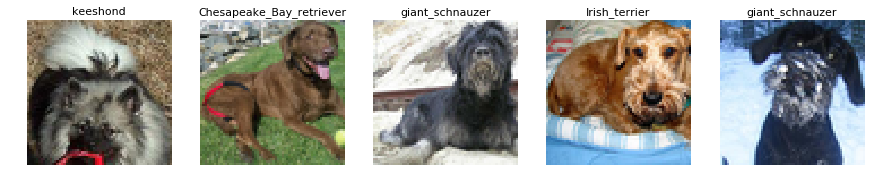

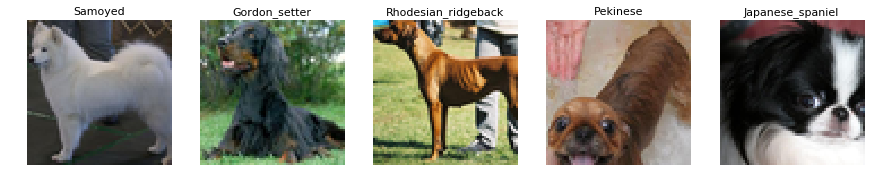

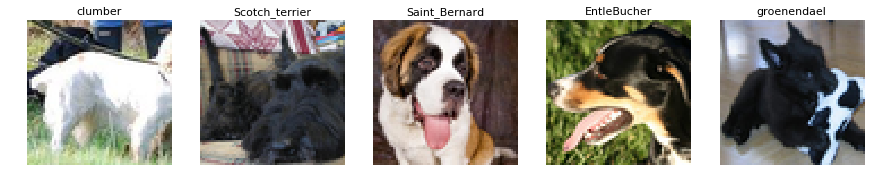

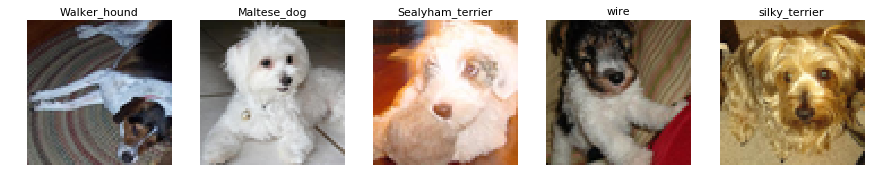

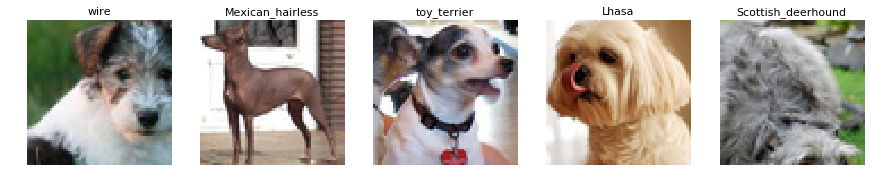

In [20]:
dog_images.shape
x = np.random.randint(0,index,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( ((dog_images[x[k*5+j],:,:,:]*127.5)+127.5).astype('uint8') )
        plt.axis('off')
        if not True: plt.title(names[x[k*5+j]],fontsize=11)
        else: plt.title(names[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [ ]:
BUFFER_SIZE = 5000
BATCH_SIZE = 32

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(dog_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 512)))
    assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 64 x 64
    # model.add(layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 64, 64, 3)

    # 128x128
    model.add(layers.Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 128, 128, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3, (2, 2), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    
    

    return model

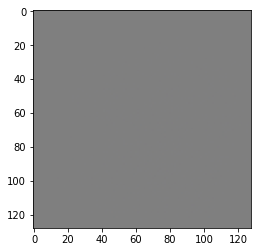

In [24]:
# untrained Generator
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]*127.5 +127.5)/255)

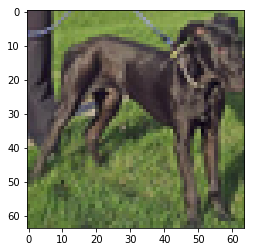

In [25]:
plt.imshow((dog_images[3, :, :, :]*127.5+127.5)/255)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [3]:
#untrained discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

NameError: name 'make_discriminator_model' is not defined

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
learningRate = 0.0002
beta = 0.6

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate, beta_1=beta,)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate, beta_1=beta,)

In [ ]:
checkpoint_dir = './modelsCheckpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                    discriminator_optimizer=discriminator_optimizer,
                                    generator=generator,
                                    discriminator=discriminator)

In [ ]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)
    

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]*127.5 +127.5)/255)
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
try:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
except:
    print('No checkpoint found')

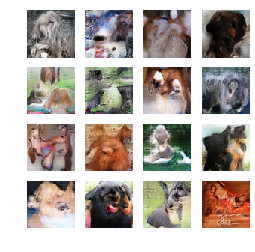

Time for epoch 86 is 29.549270153045654 sec


KeyboardInterrupt: ignored

In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

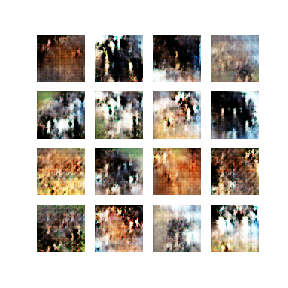

In [ ]:
display_image(200)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [ ]:
import shutil

In [ ]:
shutil.make_archive('modelCheckpoints', 'zip', 'training_checkpoints')

'/content/modelCheckpoints.zip'

In [ ]:
!cp modelCheckpoints.zip /content/drive/My\ Drive/kaggle

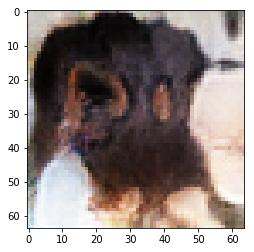

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow((generated_image[0, :, :, :]*127.5 +127.5)/255)

In [ ]:
!cp modelCheckpoints.zip /content/drive/My\ Drive/kaggle

cp: cannot stat 'modelCheckpoints.zip': No such file or directory


In [ ]:
!rm -rf modelsCheckpoints